In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0518_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0656

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - loss: 0.0573
Average validation loss: 0.12917038798332214
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.0573 - val_loss: 0.1292
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - loss: 0.0425 - val_loss: 0.1292
Average validation loss: 0.12667833268642426
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - loss: 0.0425 - val_loss: 0.1279
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0348 - val_loss: 0.1279
Average validation loss: 0.12743060290813446
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step - loss: 0.0348 - val_loss: 0.1278
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - loss: 0.0287 - val_loss: 0.1278
Average validation loss: 0.13563910126686096
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 522ms/step - loss: 0.0287 - val_loss: 0.129

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 807ms/step - loss: 0.0027
Average validation loss: 0.12441001832485199
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 818ms/step - loss: 0.0027 - val_loss: 0.1244
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0026 - val_loss: 0.1244
Average validation loss: 0.13830427080392838
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 926ms/step - loss: 0.0026 - val_loss: 0.1314
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - loss: 0.0025 - val_loss: 0.1314
Average validation loss: 0.13670311123132706
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 828ms/step - loss: 0.0025 - val_loss: 0.1331
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 833ms/step - loss: 0.0024 - val_loss: 0.1331
Average validation loss: 0.15364158153533936
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 844ms/step - loss: 0.0024 - val_loss: 0.1383
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 825ms/step - loss: 0.0024 - val_loss: 0.1383
Average validation

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 935ms/step - loss: 0.0016
Average validation loss: 0.09643032898505528
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 950ms/step - loss: 0.0016 - val_loss: 0.0964
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 847ms/step - loss: 0.0015 - val_loss: 0.0964
Average validation loss: 0.1302738438049952
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 863ms/step - loss: 0.0015 - val_loss: 0.1134
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 877ms/step - loss: 0.0014 - val_loss: 0.1134
Average validation loss: 0.18981715043385824
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 892ms/step - loss: 0.0014 - val_loss: 0.1388
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 865ms/step - loss: 0.0013 - val_loss: 0.1388
Average validation loss: 0.13671771685282388
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 879ms/step - loss: 0.0013 - val_loss: 0.1383
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 892ms/step - loss: 0.0012 - val_loss: 0.1383

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - loss: 7.0013e-04
Average validation loss: 0.11292209476232529
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 886ms/step - loss: 7.0013e-04 - val_loss: 0.1129
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 818ms/step - loss: 6.5412e-04 - val_loss: 0.1129
Average validation loss: 0.1465412676334381
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 831ms/step - loss: 6.5412e-04 - val_loss: 0.1297
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 5.8173e-04 - val_loss: 0.1297
Average validation loss: 0.1381303332746029
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - loss: 5.8173e-04 - val_loss: 0.1325
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 831ms/step - loss: 5.2816e-04 - val_loss: 0.1325
Average validation loss: 0.13342374935746193
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 844ms/step - loss: 5.2816e-04 - val_loss: 0.1328
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 816ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 822ms/step - loss: 7.6371e-04
Average validation loss: 0.11719186007976531
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 835ms/step - loss: 7.6371e-04 - val_loss: 0.1172
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 795ms/step - loss: 6.6085e-04 - val_loss: 0.1172
Average validation loss: 0.13500624001026154
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 807ms/step - loss: 6.6085e-04 - val_loss: 0.1261
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 805ms/step - loss: 5.6797e-04 - val_loss: 0.1261
Average validation loss: 0.14754024744033814
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 817ms/step - loss: 5.6797e-04 - val_loss: 0.1332
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 828ms/step - loss: 5.0684e-04 - val_loss: 0.1332
Average validation loss: 0.1349570631980896
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 839ms/step - loss: 5.0684e-04 - val_loss: 0.1337
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 800ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 812ms/step - loss: 8.1517e-04
Average validation loss: 0.1295738766590754
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - loss: 8.1517e-04 - val_loss: 0.1296
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 823ms/step - loss: 6.4878e-04 - val_loss: 0.1296
Average validation loss: 0.13970390458901724
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 836ms/step - loss: 6.4878e-04 - val_loss: 0.1346
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 796ms/step - loss: 5.5469e-04 - val_loss: 0.1346
Average validation loss: 0.13211299230655035
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 807ms/step - loss: 5.5469e-04 - val_loss: 0.1338
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 798ms/step - loss: 5.4252e-04 - val_loss: 0.1338
Average validation loss: 0.1361627901593844
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 809ms/step - loss: 5.4252e-04 - val_loss: 0.1344
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 799ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 803ms/step - loss: 8.4717e-04
Average validation loss: 0.13553826063871383
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - loss: 8.4717e-04 - val_loss: 0.1355
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 844ms/step - loss: 6.8445e-04 - val_loss: 0.1355
Average validation loss: 0.14176522493362426
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 857ms/step - loss: 6.8445e-04 - val_loss: 0.1387
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 792ms/step - loss: 5.8073e-04 - val_loss: 0.1387
Average validation loss: 0.1393171012401581
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 805ms/step - loss: 5.8073e-04 - val_loss: 0.1389
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 809ms/step - loss: 5.4438e-04 - val_loss: 0.1389
Average validation loss: 0.13353724479675294
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 822ms/step - loss: 5.4438e-04 - val_loss: 0.1375
Saved model weights to 'c:\天_11157065\RipplesDetecti

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 797ms/step - loss: 5.6429e-04
Average validation loss: 0.13448111588756242
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 811ms/step - loss: 5.6429e-04 - val_loss: 0.1345
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 802ms/step - loss: 4.9000e-04 - val_loss: 0.1345
Average validation loss: 0.13262393325567245
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - loss: 4.9000e-04 - val_loss: 0.1336
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 809ms/step - loss: 4.4017e-04 - val_loss: 0.1336
Average validation loss: 0.134606105585893
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 824ms/step - loss: 4.4017e-04 - val_loss: 0.1339
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 819ms/step - loss: 3.9303e-04 - val_loss: 0.1339
Average validation loss: 0.13832844172914824
48/48 ━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 832ms/step - loss: 3.9142e-04
Average validation loss: 0.14275204496724264
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 846ms/step - loss: 3.9142e-04 - val_loss: 0.1428
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 819ms/step - loss: 3.4086e-04 - val_loss: 0.1428
Average validation loss: 0.13606635268245423
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 833ms/step - loss: 3.4086e-04 - val_loss: 0.1394
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 816ms/step - loss: 3.2065e-04 - val_loss: 0.1394
Average validation loss: 0.13594489012445723
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 830ms/step - loss: 3.2065e-04 - val_loss: 0.1383
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 187

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 798ms/step - loss: 4.0130e-04
Average validation loss: 0.1386744501069188
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 812ms/step - loss: 4.0130e-04 - val_loss: 0.1387
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 798ms/step - loss: 3.4162e-04 - val_loss: 0.1387
Average validation loss: 0.13605258986353874
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 811ms/step - loss: 3.4162e-04 - val_loss: 0.1374
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 798ms/step - loss: 3.0225e-04 - val_loss: 0.1374
Average validation loss: 0.13773292303085327
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 811ms/step - loss: 3.0225e-04 - val_loss: 0.1375
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 798ms/step - loss: 2.7725e-04 - val_loss: 0.1375
Average validation loss: 0.14029995258897543
64/64 ━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 794ms/step - loss: 3.4176e-04
Average validation loss: 0.13819677382707596
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 808ms/step - loss: 3.4176e-04 - val_loss: 0.1382
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 790ms/step - loss: 2.9175e-04 - val_loss: 0.1382
Average validation loss: 0.13469825519455803
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 802ms/step - loss: 2.9175e-04 - val_loss: 0.1364
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 800ms/step - loss: 2.5821e-04 - val_loss: 0.1364
Average validation loss: 0.13696599089437062
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 813ms/step - loss: 2.5821e-04 - val_loss: 0.1366
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 232s 803ms/step - loss: 2.4184e-04 - val_loss: 0.1366
Average validation loss: 0.1363709411687321
72/72 ━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 800ms/step - loss: 2.5872e-04
Average validation loss: 0.13563421219587327
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 813ms/step - loss: 2.5872e-04 - val_loss: 0.1356
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 802ms/step - loss: 2.5301e-04 - val_loss: 0.1356
Average validation loss: 0.13841618075966836
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 816ms/step - loss: 2.5301e-04 - val_loss: 0.1370
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 795ms/step - loss: 2.4123e-04 - val_loss: 0.1370
Average validation loss: 0.13751933723688126
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 808ms/step - loss: 2.4123e-04 - val_loss: 0.1372
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 259s 806ms/step - loss: 2.2745e-04 - val_loss: 0.1372
Average validation loss: 0.1378435179591179
80/80 ━━━━━━━━━━━━━━━━━━━━ 260s 819ms/step - loss: 2.2745e-04 - val_loss: 0.1374
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 324s 797m

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 802ms/step - loss: 3.3916e-04
Average validation loss: 0.13790803526838621
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 815ms/step - loss: 3.3916e-04 - val_loss: 0.1379
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 805ms/step - loss: 2.8332e-04 - val_loss: 0.1379
Average validation loss: 0.14313689370950064
96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 819ms/step - loss: 2.8332e-04 - val_loss: 0.1405
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 800ms/step - loss: 2.5539e-04 - val_loss: 0.1405
Average validation loss: 0.1402812246233225
96/96 ━━━━━━━━━━━━━━━━━━━━ 235s 814ms/step - loss: 2.5539e-04 - val_loss: 0.1404
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 312s 796ms/step - loss: 2.4193e-04 - val_loss: 0.1404
Average validation loss: 0.13999261893332005
96/96 ━━━━━━━━━━━━━━━━━━━━ 313s 810ms/step - loss: 2.4193e-04 - val_loss: 0.1403
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 389s 796m

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 798ms/step - loss: 5.4839e-04
Average validation loss: 0.13872796595096587
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 811ms/step - loss: 5.4839e-04 - val_loss: 0.1387
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 803ms/step - loss: 4.3936e-04 - val_loss: 0.1387
Average validation loss: 0.1392800698677699
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 816ms/step - loss: 4.3936e-04 - val_loss: 0.1390
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 799ms/step - loss: 3.7947e-04 - val_loss: 0.1390
Average validation loss: 0.1368783195813497
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 812ms/step - loss: 3.7947e-04 - val_loss: 0.1383
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 801ms/step - loss: 3.5006e-04 - val_loss: 0.1383
Average validation loss: 0.13771644483009973
1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 818ms/step - loss: 4.2944e-04
Average validation loss: 0.1355928493042787
144/144 ━━━━━━━━━━━━━━━━━━━━ 120s 831ms/step - loss: 4.2944e-04 - val_loss: 0.1356
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 239s 824ms/step - loss: 3.6393e-04 - val_loss: 0.1356
Average validation loss: 0.137249902718597
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 838ms/step - loss: 3.6393e-04 - val_loss: 0.1364
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 358s 813ms/step - loss: 3.3116e-04 - val_loss: 0.1364
Average validation loss: 0.13610218258367646
144/144 ━━━━━━━━━━━━━━━━━━━━ 359s 827ms/step - loss: 3.3116e-04 - val_loss: 0.1363
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 474s 798ms/step - loss: 3.0877e-04 - val_loss: 0.1363
Average validation loss: 0.13453837277160752
144/144 ━━━━━━━━━━━━━━━━━━━━ 476s 811ms/step - loss: 3.0877e-04 - val_loss: 0.1359
Saved model weights to 'c:\天_11

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 810ms/step - loss: 3.0762e-04
Average validation loss: 0.14168857038021088
160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 824ms/step - loss: 3.0762e-04 - val_loss: 0.1417
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 795ms/step - loss: 2.8270e-04 - val_loss: 0.1417
Average validation loss: 0.13806281946599483
160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 808ms/step - loss: 2.8270e-04 - val_loss: 0.1399
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 795ms/step - loss: 2.5623e-04 - val_loss: 0.1399
Average validation loss: 0.14172554425895215
160/160 ━━━━━━━━━━━━━━━━━━━━ 391s 808ms/step - loss: 2.5623e-04 - val_loss: 0.1405
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 519s 801ms/step - loss: 2.4038e-04 - val_loss: 0.1405
Average validation loss: 0.141585839912295

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 802ms/step - loss: 3.1223e-04
Average validation loss: 0.13989015340805053
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 3.1223e-04 - val_loss: 0.1399
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 794ms/step - loss: 2.8052e-04 - val_loss: 0.1399
Average validation loss: 0.14016068249940872
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 807ms/step - loss: 2.8052e-04 - val_loss: 0.1400
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 796ms/step - loss: 2.5957e-04 - val_loss: 0.1400
Average validation loss: 0.14233789831399918
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 809ms/step - loss: 2.5957e-04 - val_loss: 0.1408
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 646s 797ms/step - loss: 2.4253e-04 - val_loss: 0.1408
Average validation loss: 0.13922733157873154
200/200 ━━━━━━━━━━━━━━━━━━━━ 648s 810ms/step - loss: 2.4253e-04 - val_loss: 0.1404
Saved model weights to 'c:\天

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - loss: 2.7588e-04
Average validation loss: 0.1376124329864979
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 2.7588e-04 - val_loss: 0.1376
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 386s 801ms/step - loss: 2.5662e-04 - val_loss: 0.1376
Average validation loss: 0.14491306021809577
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 814ms/step - loss: 2.5662e-04 - val_loss: 0.1413
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 581s 796ms/step - loss: 2.3430e-04 - val_loss: 0.1413
Average validation loss: 0.15037780900796255
240/240 ━━━━━━━━━━━━━━━━━━━━ 584s 809ms/step - loss: 2.3430e-04 - val_loss: 0.1443
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 776s 801ms/step - loss: 2.2163e-04 - val_loss: 0.1443
Average validation loss: 0.14007185871402422
240/240 ━━━━━━━━━━━━━━━━━━━━ 779s 814ms/step - loss: 2.2163e-04 - val_loss: 0.1432
Epoch 5/10
240/240 ━━━━━━━━━━

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1460381593927741, 0.12433086261153221, 0.13160848960280416, 0.1351606336236, 0.13349725404381751, 0.13523694269359113, 0.1356944962143898, 0.13677100093414388, 0.13793409628527503, 0.13737460417672992, 0.13800815208090675, 0.13811014661192894, 0.13946994341909885, 0.1394394166668256, 0.14026722555359203, 0.1413280284292996, 0.14333064169287682, 0.1438640466084083]
std_val_losses =  [0.14510685025873088, 0.01551414801405424, 0.015968312379224553, 0.009119222098003569, 0.0075404069145903465, 0.008095644054963307, 0.004533763507063189, 0.003251936813503071, 0.0028816961980512486, 0.002998559965826869, 0.0033982756023213487, 0.002896398170328596, 0.002978895305520709, 0.0035055579274885784, 0.003543861915234767, 0.0027133281060952624, 0.004368691983132462, 0.0043301674849170165]


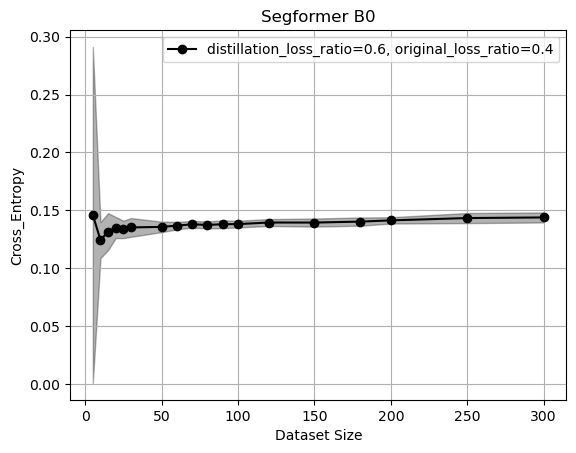

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()